# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [ ]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from six import StringIO  ### Sean: I changed the next line to this line
# from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from scipy.interpolate import make_interp_spline ### Sean: I changed the next line to this line
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:

# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)

    all_perc_diff = []

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass

    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False

    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break

    return out

## Define a default random seed and an output file

In [ ]:
default_seed = 1
output_file = "MLPS_Phase3_output_sample"

In [ ]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "/content/gdrive/MyDrive/clean_data.pickle", "rb" ) )

In [ ]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].apply(lambda info: True if info in ['Charged Off', 'Default'] else False)

In [ ]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [ ]:
# For Question3_ parti
feature_names = list(data.columns)
print("Total features:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i}. {feature}")

Total features:
1. id
2. loan_amnt
3. funded_amnt
4. term
5. int_rate
6. grade
7. emp_length
8. home_ownership
9. annual_inc
10. verification_status
11. issue_d
12. loan_status
13. purpose
14. dti
15. delinq_2yrs
16. earliest_cr_line
17. open_acc
18. pub_rec
19. fico_range_high
20. fico_range_low
21. revol_bal
22. revol_util
23. total_pymnt
24. recoveries
25. last_pymnt_d
26. loan_length
27. term_num
28. ret_PESS
29. ret_OPT
30. ret_INTa
31. ret_INTb
32. outcome
33. cr_hist


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a copy of the dataset
data_copy = data.copy()

# Encode the 'grade' feature
le = LabelEncoder()
data_copy['grade'] = le.fit_transform(data_copy['grade'])

# Calculate the correlation matrix
correlation_matrix = data_copy.corr()

# Get the correlation of 'dti' and 'grade' with other features
dti_corr = correlation_matrix['dti'].sort_values(ascending=False)
grade_corr = correlation_matrix['grade'].sort_values(ascending=False)

# Print the correlations
print("Correlation of 'dti' with other features:\n", dti_corr)
print("\nCorrelation of 'grade' with other features:\n", grade_corr)

Correlation of 'dti' with other features:
 dti                1.000000
open_acc           0.306561
revol_bal          0.246274
grade              0.174839
int_rate           0.174219
revol_util         0.160950
outcome            0.108130
term_num           0.064657
funded_amnt        0.060422
loan_amnt          0.059855
recoveries         0.057563
cr_hist            0.049041
total_pymnt        0.002041
delinq_2yrs       -0.008955
loan_length       -0.015316
fico_range_low    -0.031265
fico_range_high   -0.031265
pub_rec           -0.033272
ret_OPT           -0.068176
ret_PESS          -0.084111
ret_INTb          -0.090290
ret_INTa          -0.092941
annual_inc        -0.212195
Name: dti, dtype: float64

Correlation of 'grade' with other features:
 grade              1.000000
int_rate           0.945908
term_num           0.388299
outcome            0.264987
revol_util         0.227818
recoveries         0.199710
dti                0.174839
loan_amnt          0.113518
funded_amnt      

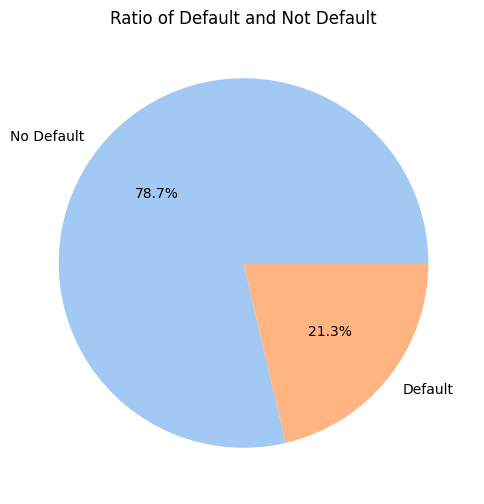

In [ ]:
default_ratio = data['outcome'].value_counts(normalize=True)

plt.figure(figsize=(6, 6))
labels = ['No Default', 'Default']
colors = sns.color_palette('pastel')
plt.pie(default_ratio, labels=labels, colors=colors, autopct='%.1f%%')
plt.title('Ratio of Default and Not Default')
plt.show()

In [ ]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])

In [ ]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [ ]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows

    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.

    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''

    np.random.seed(random_state)

    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values

    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False

    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]

    y_train = y[ filter_train ]
    y_test = y[ filter_test ]

    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}

    return out

In [ ]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.

    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.

    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not
                      output probabilities.
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']

    X_test = data_dict['X_test']
    y_test = data_dict['y_test']

    filter_train = data_dict['train_set']

    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, n_jobs = -1)

    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()

    best_model = cv_model.best_estimator_

    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")

    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------

    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

        probs_predicted = True
    except:
        probs_predicted = False

    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)

        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()

        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]

        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))

        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)

    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')

            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')

            #plt.tight_layout()
            plt.show()

    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)

    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)

    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)

    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}

    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})

    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))

        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))

        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )

        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )

    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [ ]:
## define your set of features to use in different models

# we can use current whole set to train the models
your_features = continuous_features + discrete_features

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Random Classifier
Fit time: 2.29 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7845
              precision    recall  f1-score   support

  No default     0.7845    1.0000    0.8792     15690
     Default     0.0000    0.0000    0.0000      4310

    accuracy                         0.7845     20000
   macro avg     0.3922    0.5000    0.4396     20000
weighted avg     0.6154    0.7845    0.6898     20000



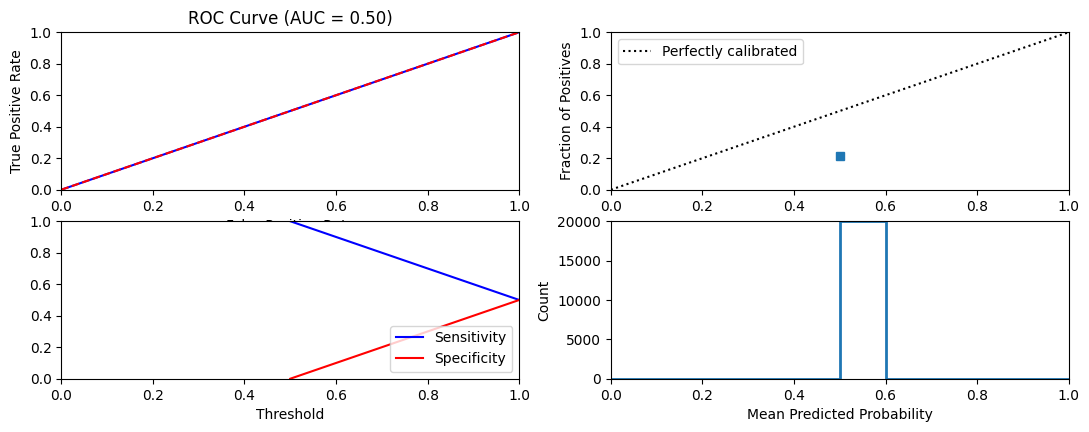


Similarity to LC grade ranking:  nan
Brier score: 0.25


In [ ]:
# Random Classfier used as a baseline
from sklearn.dummy import DummyClassifier

random_clf = DummyClassifier(strategy='uniform', random_state=42)

random_clf = fit_classification(model=random_clf, data_dict=data_dict, model_name="Random Classifier", output_to_file=False)

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 3.93 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999999967645863
Accuracy:  0.7843
              precision    recall  f1-score   support

  No default     0.7980    0.9708    0.8760     15690
     Default     0.4978    0.1053    0.1739      4310

    accuracy                         0.7843     20000
   macro avg     0.6479    0.5381    0.5249     20000
weighted avg     0.7333    0.7843    0.7247     20000



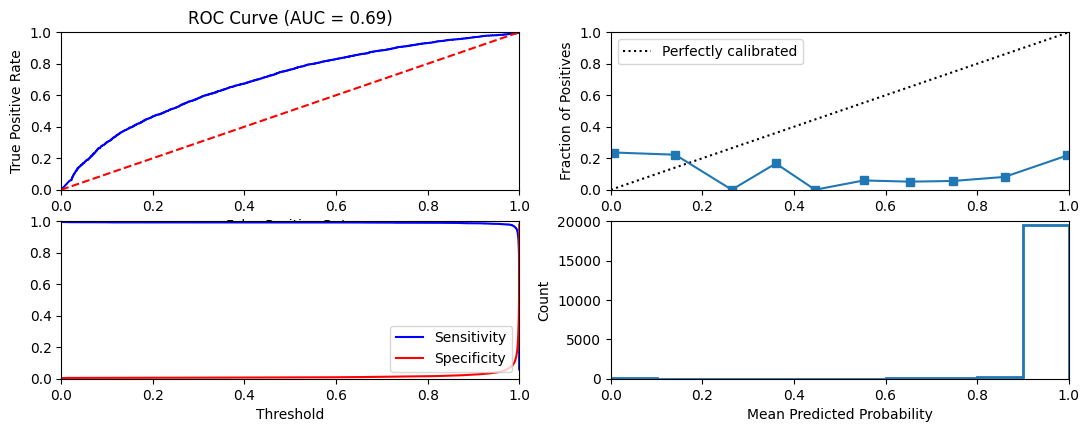


Similarity to LC grade ranking:  0.6281644739420982
Brier score: 0.7692671298787302


In [ ]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(model=gnb, data_dict=data_dict, model_name="Gaussian Naive Bayes", output_to_file=False)

### $l_1$ regularized logistic regression

  Model: l1_regularized_logistic_regression
Fit time: 5.87 seconds
Optimal parameters:
{'solver': 'saga'}

Accuracy-maximizing threshold was: 0.49150693798801304
Accuracy:  0.79725
              precision    recall  f1-score   support

  No default     0.8067    0.9751    0.8830     15690
     Default     0.6232    0.1497    0.2413      4310

    accuracy                         0.7973     20000
   macro avg     0.7150    0.5624    0.5622     20000
weighted avg     0.7672    0.7973    0.7447     20000



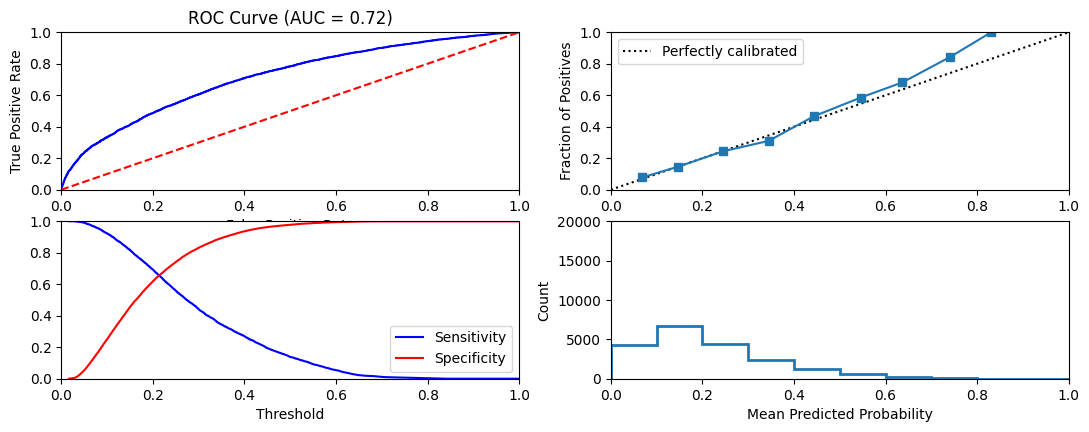


Similarity to LC grade ranking:  0.6535564315131083
Brier score: 0.14972732270415134


In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters,
                                   model_name ='l1_regularized_logistic_regression',
                                   output_to_file=False)

### $l_2$ regularized logistic regression

In [ ]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = RidgeClassifier()
cv_parameters = {'alpha': [1, 0.1, 0.05, 0.01, 0.001]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters,
                                   model_name ='l2_regularized_logistic_regression',
                                   output_to_file=False)

  Model: l2_regularized_logistic_regression
Fit time: 2.0 seconds
Optimal parameters:
{'alpha': 1}

Accuracy:  0.7924
              precision    recall  f1-score   support

  No default     0.7959    0.9890    0.8820     15690
     Default     0.6574    0.0766    0.1372      4310

    accuracy                         0.7924     20000
   macro avg     0.7266    0.5328    0.5096     20000
weighted avg     0.7660    0.7924    0.7215     20000


Similarity to LC grade ranking:  0.5925675163639829


  Model: l2_regularized_logistic_regression
Fit time: 44.08 seconds
Optimal parameters:
{'C': 1, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4711705821878317
Accuracy:  0.79355
              precision    recall  f1-score   support

  No default     0.8074    0.9676    0.8803     15690
     Default     0.5756    0.1599    0.2502      4310

    accuracy                         0.7935     20000
   macro avg     0.6915    0.5637    0.5653     20000
weighted avg     0.7575    0.7935    0.7445     20000



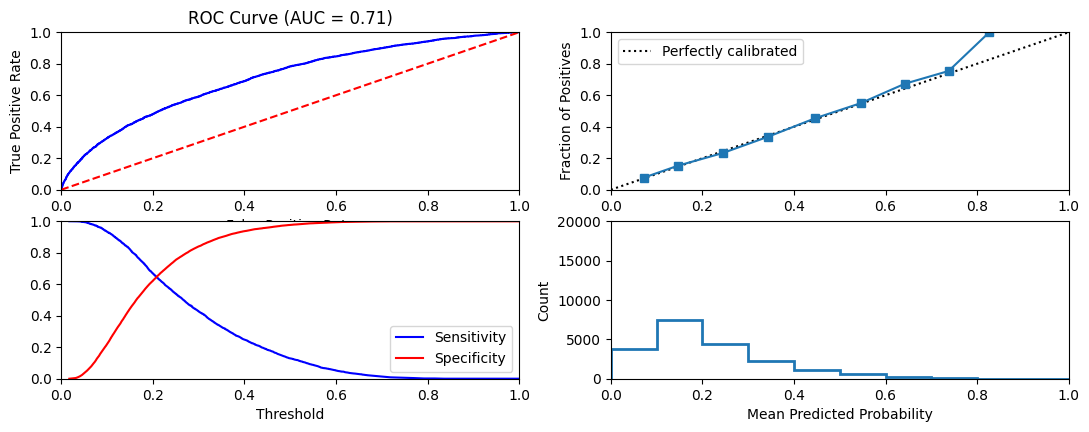


Similarity to LC grade ranking:  0.5885382783056221
Brier score: 0.15103167819978497


In [ ]:
# We apply another L2 logistic regression because it helps generate AUC and Brier score
l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {
    'C' : [1, 0.1, 0.05, 0.01, 0.001],
    'solver': ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"],
}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters,
                                   model_name ='l2_regularized_logistic_regression',
                                   output_to_file=False)

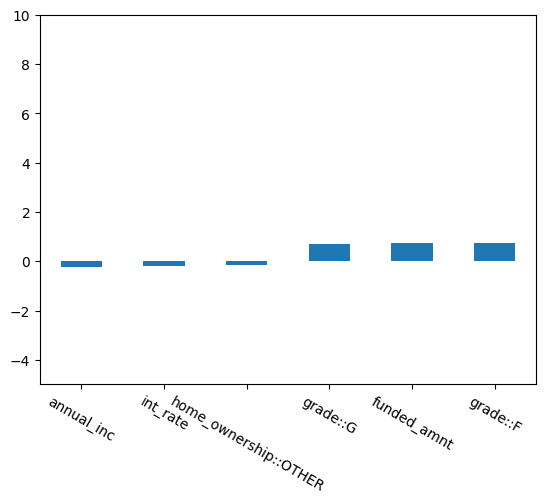

In [ ]:
## plot top 3 features with the most positive (and negative) weights
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision_Tree_First_Approach
Fit time: 847.95 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 41, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 0.5079365079365079
Accuracy:  0.7967
              precision    recall  f1-score   support

  No default     0.7984    0.9911    0.8844     15690
     Default     0.7328    0.0891    0.1589      4310

    accuracy                         0.7967     20000
   macro avg     0.7656    0.5401    0.5216     20000
weighted avg     0.7843    0.7967    0.7280     20000



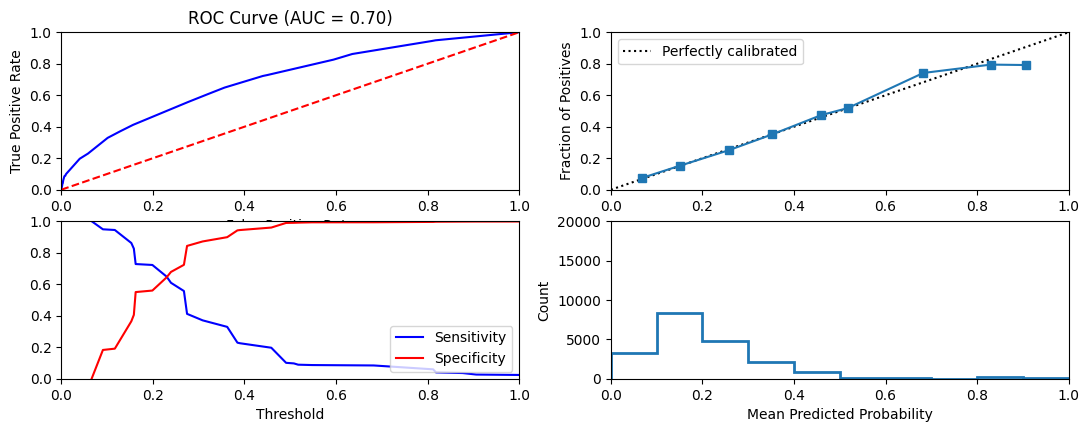


Similarity to LC grade ranking:  0.7717078409415927
Brier score: 0.1506797053907391


In [ ]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion': ['gini', 'entropy'],
                 'max_depth': [int(i) for i in range(5, 50, 5)],
                 'min_samples_split': range(2, 63, 20),
                 'min_samples_leaf': range(1, 42, 20)}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters,
                                   model_name ='Decision_Tree_First_Approach',
                                   output_to_file=False)

### Random forest

  Model: Random_Froest_First_Approach
Fit time: 376.51 seconds
Optimal parameters:
{'max_depth': 45, 'n_estimators': 201, 'random_state': 1}

Accuracy-maximizing threshold was: 0.5572139303482587
Accuracy:  0.8
              precision    recall  f1-score   support

  No default     0.8014    0.9904    0.8860     15690
     Default     0.7541    0.1067    0.1870      4310

    accuracy                         0.8000     20000
   macro avg     0.7778    0.5486    0.5365     20000
weighted avg     0.7912    0.8000    0.7353     20000



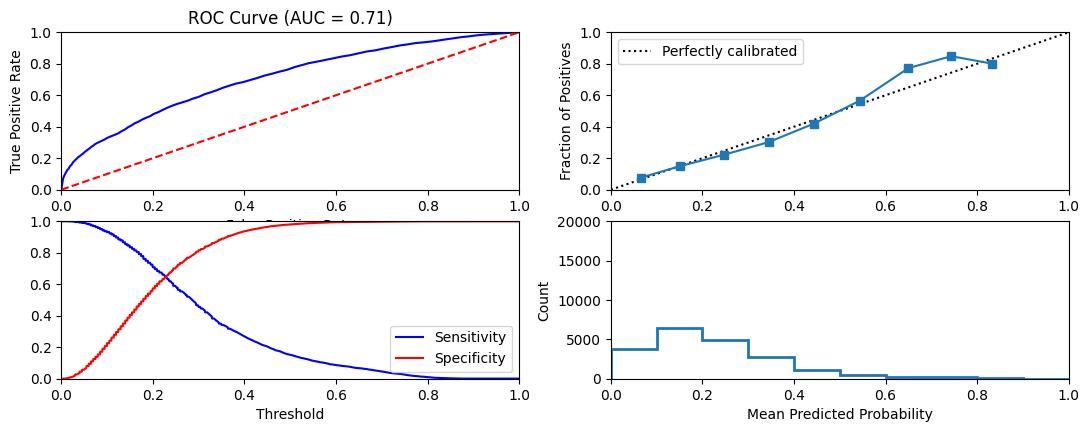


Similarity to LC grade ranking:  0.5035919008230306
Brier score: 0.14974250919528675


In [ ]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {"n_estimators": [1, 201, 50],
                 'max_depth': [int(i) for i in range(5, 100, 20)],
                 "random_state":[default_seed]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters,
                                   model_name ='Random_Froest_First_Approach',
                                   output_to_file=False)

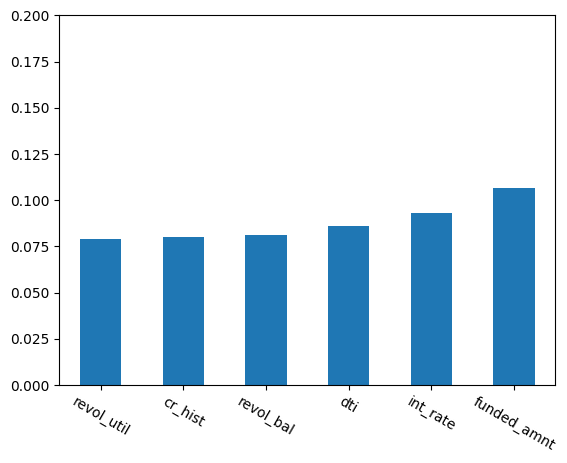

In [ ]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:])
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: multi-layer perceptron classifier
Fit time: 222.2 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001}

Accuracy-maximizing threshold was: 0.4858577702945825
Accuracy:  0.80145
              precision    recall  f1-score   support

  No default     0.8088    0.9781    0.8854     15690
     Default     0.6650    0.1585    0.2559      4310

    accuracy                         0.8014     20000
   macro avg     0.7369    0.5683    0.5707     20000
weighted avg     0.7778    0.8014    0.7498     20000



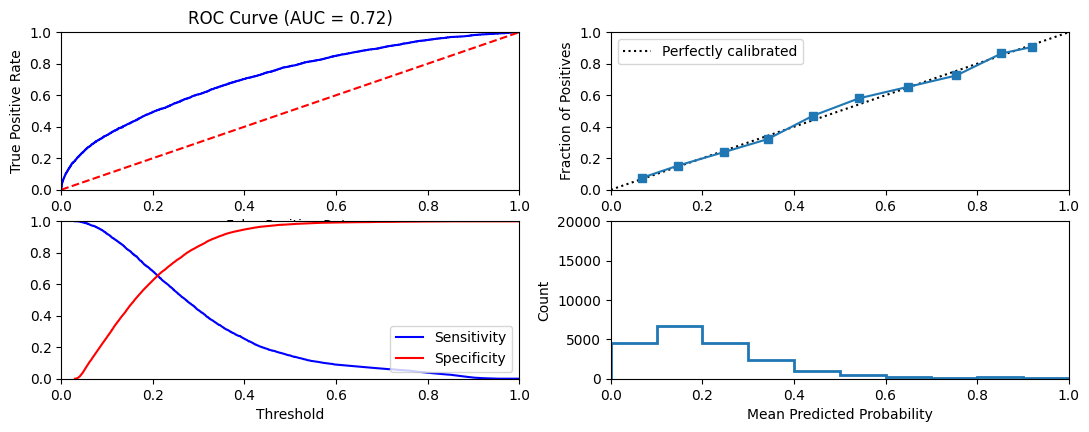


Similarity to LC grade ranking:  0.6602540444490432
Brier score: 0.14783156684726342


In [ ]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()

# 1st round tune
# cv_parameters = {'hidden_layer_sizes': [tuple([y] * x) for x in [5, 10] for y in [10, 20]],
#                  'alpha' : [1e-03, 1e-02], 'activation': ['tanh', 'relu'],
#                  'learning_rate_init': [1e-04, 1e-03]}


# Optimal parameters 1st round:
# {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (20, 20, 20, 20, 20), 'learning_rate_init': 0.0001}


# 2nd round tune
# cv_parameters = {'hidden_layer_sizes': [tuple([y] * x) for x in [3,5] for y in [15, 18]],
#                  'alpha' : [1e-02], 'activation': ['tanh', 'relu'],
#                  'learning_rate_init': [1e-04]}

# optimal one
cv_parameters = {'hidden_layer_sizes': [(18, 18, 18, 18, 18)],
                 'alpha' : [1e-02], 'activation': ['tanh'],
                 'learning_rate_init': [1e-04]}

mlp = fit_classification(mlp, data_dict,model_name ='multi-layer perceptron classifier',
                         output_to_file=False, cv_parameters=cv_parameters, print_to_screen = True)

## Train and Test logistic regression model with features derived by LendingClub

  Model: logistic_l1_only
Fit time: 0.36 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.49998961140105846
Accuracy:  0.78465
              precision    recall  f1-score   support

  No default     0.7893    0.9897    0.8782     15690
     Default     0.5046    0.0381    0.0708      4310

    accuracy                         0.7846     20000
   macro avg     0.6469    0.5139    0.4745     20000
weighted avg     0.7279    0.7846    0.7042     20000



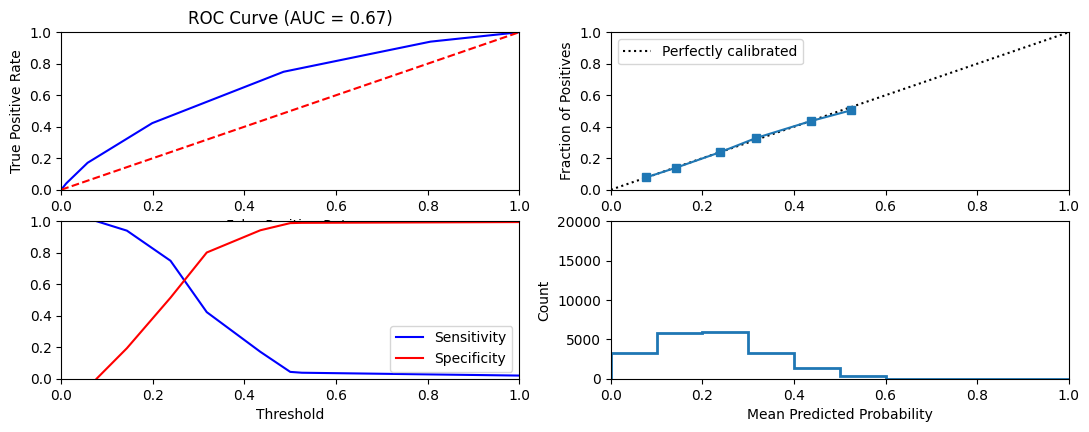


Similarity to LC grade ranking:  0.9997624593712833
Brier score: 0.1575199008840056
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.78383333]


In [ ]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature

## The LendingClub-defined feature
lendingclub_feature = ['grade', 'id', 'dti']

# The LendingClub feature to be examined
a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', solver='liblinear')

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict,
                                       model_name ='logistic_l1_only')

  Model: logistic_l2_only
Fit time: 0.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.48063796737322784
Accuracy:  0.78465
              precision    recall  f1-score   support

  No default     0.7893    0.9897    0.8782     15690
     Default     0.5046    0.0381    0.0708      4310

    accuracy                         0.7846     20000
   macro avg     0.6469    0.5139    0.4745     20000
weighted avg     0.7279    0.7846    0.7042     20000



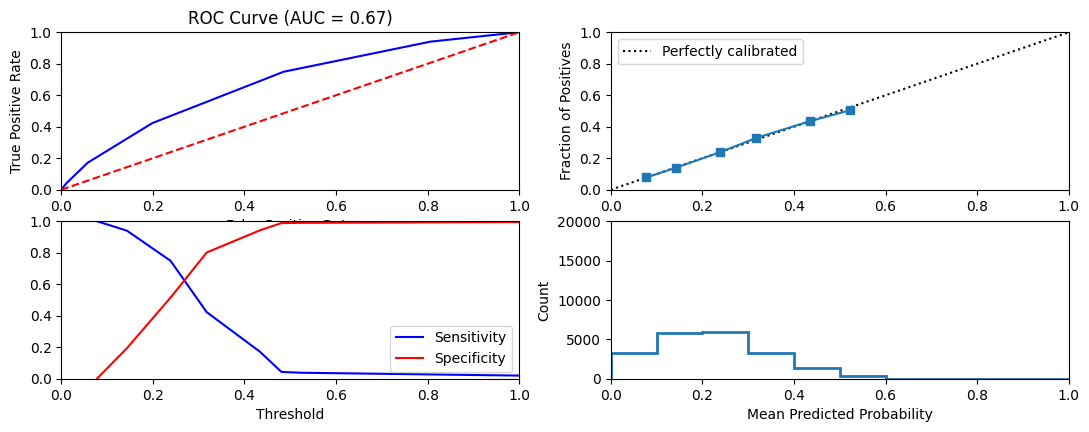


Similarity to LC grade ranking:  0.9997624593712833
Brier score: 0.15751568389457046
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.7839]


In [ ]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict,
                                       model_name ='logistic_l2_only')

## Train and test all the models you have tried previously after removing features derived by LendingClub

In [ ]:
from sklearn.metrics import f1_score
# Features we are going to use in this question
your_features = ['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'int_rate',
 'revol_util',
 'cr_hist',
 'emp_length',
 'home_ownership',
 'term',
 'purpose',
 'verification_status']


In [ ]:
## For Decision Tree

decision_tree = DecisionTreeClassifier(criterion='gini',max_depth=5,min_samples_leaf=1,min_samples_split=22)

num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)


  one_decision_tree = fit_classification(decision_tree, one_data_dict,
                                     model_name ='Decision_Tree_Removed_Derived_Features',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_decision_tree['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_decision_tree['y_pred_labels'])
  current_f1_list.append(current_f1)


print("Average Performance of Decision Tree is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')
# it's better to use F1 score because the dataset is highly imbalanced with 80% not default and 20% default
print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')

Average Performance of Decision Tree is that:
(Average Accuracy, Standard Deviation):
(0.8010615,0.0031988814842066286)
(Average F1 Score, Standard Deviation):
(0.17718164567088351,0.022857509156060853)


In [ ]:
# For Logistic Regression L1
from sklearn.metrics import f1_score

l1_logistic = LogisticRegression(penalty='l1')

cv_parameters = {'solver': ['saga']}


num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)


  one_l1_logistic = fit_classification(l1_logistic, one_data_dict, cv_parameters,
                                     model_name ='l1_regularized_logistic_regression',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_l1_logistic['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_l1_logistic['y_pred_labels'])
  current_f1_list.append(current_f1)


print("Average Performance of l1 logsitic is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')
# it's better to use F1 score because the dataset is highly imbalanced with 80% not default and 20% default
print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')

Average Performance of l1 logsitic is that:
(Average Accuracy, Standard Deviation):
(0.7970780000000001,0.0027707879745660804)
(Average F1 Score, Standard Deviation):
(0.21985725388110577,0.028701191244094666)


In [ ]:
# For Logistic Regression L2
l2_logistic = RidgeClassifier()

cv_parameters = {'alpha': [1]}

num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)


  one_l2_logistic = fit_classification(l2_logistic, one_data_dict, cv_parameters,
                                     model_name ='l2_regularized_logistic_regression',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_l2_logistic['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_l2_logistic['y_pred_labels'])
  current_f1_list.append(current_f1)


print("Average Performance of l1 logsitic is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')
# it's better to use F1 score because the dataset is highly imbalanced with 80% not default and 20% default
print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')

Average Performance of l1 logsitic is that:
(Average Accuracy, Standard Deviation):
(0.7962690000000001,0.0029891870132194814)
(Average F1 Score, Standard Deviation):
(0.14266870442019525,0.012052248139435487)


In [ ]:
## For Random Forests

random_forest = RandomForestClassifier(max_depth=45, n_estimators=201, random_state=1)

num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)

  one_random_forest = fit_classification(random_forest, one_data_dict,
                                     model_name ='Random_Forest_Removed_Derived_Features',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_random_forest['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_random_forest['y_pred_labels'])
  current_f1_list.append(current_f1)

print("Average Performance of Random Forest is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')

print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')

Average Performance of Random Forest is that:
(Average Accuracy, Standard Deviation):
(0.8025674999999999,0.002813195469568371)
(Average F1 Score, Standard Deviation):
(0.19517023079661058,0.013109728030263154)


  Model: Gaussian Naive Bayes
Fit time: 0.29 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999998054085969
Accuracy:  0.78735
              precision    recall  f1-score   support

  No default     0.8020    0.9679    0.8772     15690
     Default     0.5268    0.1299    0.2084      4310

    accuracy                         0.7873     20000
   macro avg     0.6644    0.5489    0.5428     20000
weighted avg     0.7427    0.7873    0.7331     20000



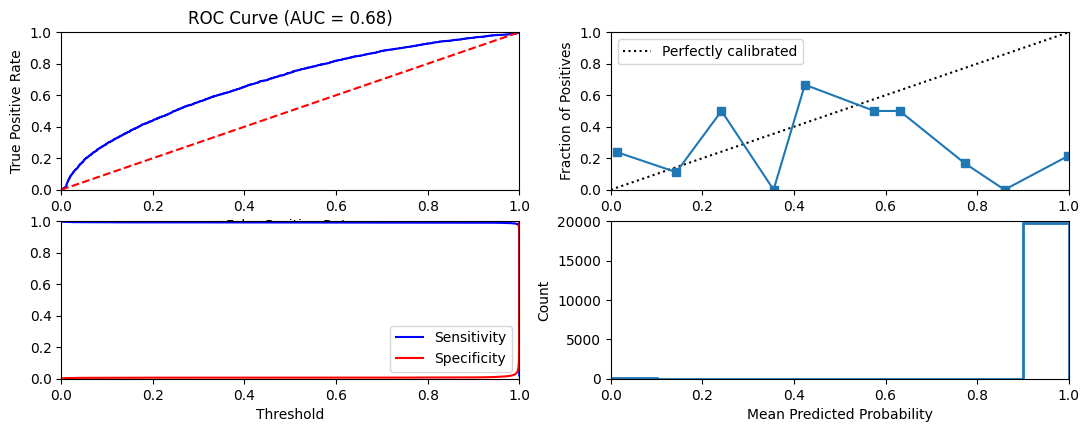


Similarity to LC grade ranking:  0.47521414153782093
Brier score: 0.778988415218515
Average Performance of Gaussian Naive Bayes is that:
(Average Accuracy, Standard Deviation):
(0.7892689999999999,0.004012535233490163)
(Average F1 Score, Standard Deviation):
(0.14360751722601853,0.10249831750334351)


In [ ]:
## For GaussianNB
from sklearn.metrics import f1_score

gnb = GaussianNB()
gnb = fit_classification(model=gnb, data_dict=data_dict, model_name="Gaussian Naive Bayes", output_to_file=False)

gnb = GaussianNB()

num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)

  one_gnb = fit_classification(gnb, one_data_dict,
                                     model_name ='Gaussian Naive Bayes_Removed_Derived_Features',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_gnb['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_gnb['y_pred_labels'])
  current_f1_list.append(current_f1)

print("Average Performance of Gaussian Naive Bayes is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')

print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')


In [ ]:
# For MLP
# copy from my best model above
mlp_optimal = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02,
                            activation='tanh', learning_rate_init=1e-04)
num_epoch = 100

current_acc_list = []
current_f1_list = []
for i in range(num_epoch):
  one_data_dict = prepare_data(feature_subset = your_features,
                           random_state = default_seed+i)

  one_random_forest = fit_classification(mlp_optimal, one_data_dict,
                                     model_name ='MLP Classifier for 100 splits',
                                     random_state=default_seed+i,
                                     print_to_screen=False,
                                     output_to_file=False)
  current_acc = accuracy_score(one_data_dict['y_test'], one_random_forest['y_pred_labels'])
  current_acc_list.append(current_acc)
  current_f1 = f1_score(one_data_dict['y_test'], one_random_forest['y_pred_labels'])
  current_f1_list.append(current_f1)

print("Average Performance of MLP Classifier is that:")
print("(Average Accuracy, Standard Deviation):")
current_acc_list = np.array(current_acc_list)
print('(' + str(np.mean(current_acc_list)) + ',' + str(np.std(current_acc_list))+')')

print("(Average F1 Score, Standard Deviation):")
current_f1_list = np.array(current_f1_list)
print('(' + str(np.mean(current_f1_list)) + ',' + str(np.std(current_f1_list))+')')


####### Please note: we ran this cell in a separated notebook since it cost too much time (> 5hrs) ########
####### The result is attached in the write-up section #######

## Assess the extent to which YourModel’s scores agree with the grades assigned by LendingClub

  Model: YourModel
Fit time: 199.26 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.47863249413969194
Accuracy:  0.79605
              precision    recall  f1-score   support

  No default     0.8061    0.9743    0.8823     15690
     Default     0.6114    0.1471    0.2371      4310

    accuracy                         0.7960     20000
   macro avg     0.7088    0.5607    0.5597     20000
weighted avg     0.7642    0.7961    0.7433     20000



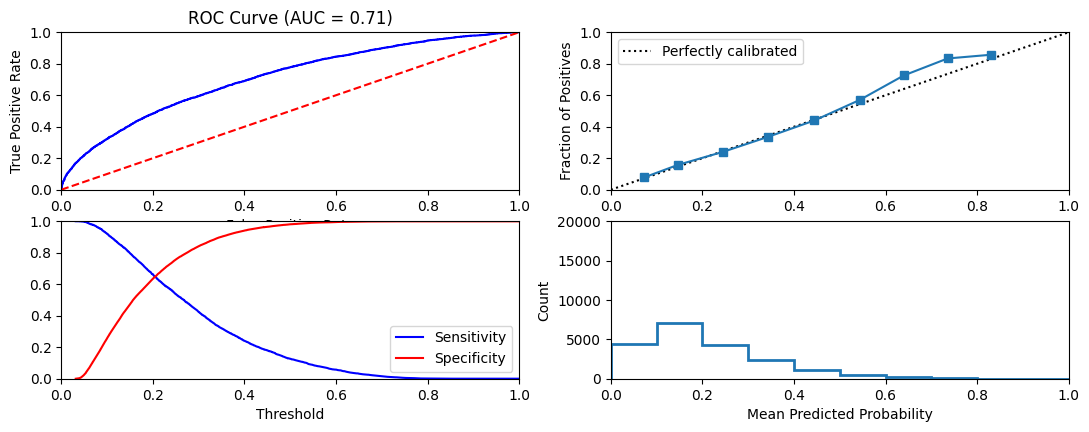


Similarity to LC grade ranking:  0.5937623504157578
Brier score: 0.15058705626562627
F1-score: 0.2371423227978305


In [ ]:
from sklearn.metrics import f1_score

# Train and test the best-performing model on data without LendingClub-derived features
your_features = ['loan_amnt',
 'funded_amnt',
 'annual_inc',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'fico_range_high',
 'fico_range_low',
 'revol_bal',
 'int_rate',
 'revol_util',
 'cr_hist',
 'emp_length',
 'home_ownership',
 'term',
 'purpose',
 'verification_status']

# Train Your-Model on data without LendingClub-derived feature
your_model = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02,
                            activation='tanh', learning_rate_init=1e-04)

data_dict = prepare_data(feature_subset=your_features)

your_model = fit_classification(your_model, data_dict,
                                   model_name ='YourModel',
                                   random_state=default_seed,
                                   print_to_screen=True,
                                   output_to_file=False)

y_pred = your_model['y_pred_labels']

# Calculate the accuracy
F1_score = f1_score(data_dict['y_test'], y_pred)
print(f"F1-score: {F1_score}")

## Time stability test of YOURMODEL

  Model: MLP_2010
Fit time: 43.87 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.4989627736155227
Accuracy:  0.7806666666666666
              precision    recall  f1-score   support

  No default     0.7808    0.9983    0.8762      2333
     Default     0.7647    0.0195    0.0380       667

    accuracy                         0.7807      3000
   macro avg     0.7727    0.5089    0.4571      3000
weighted avg     0.7772    0.7807    0.6899      3000



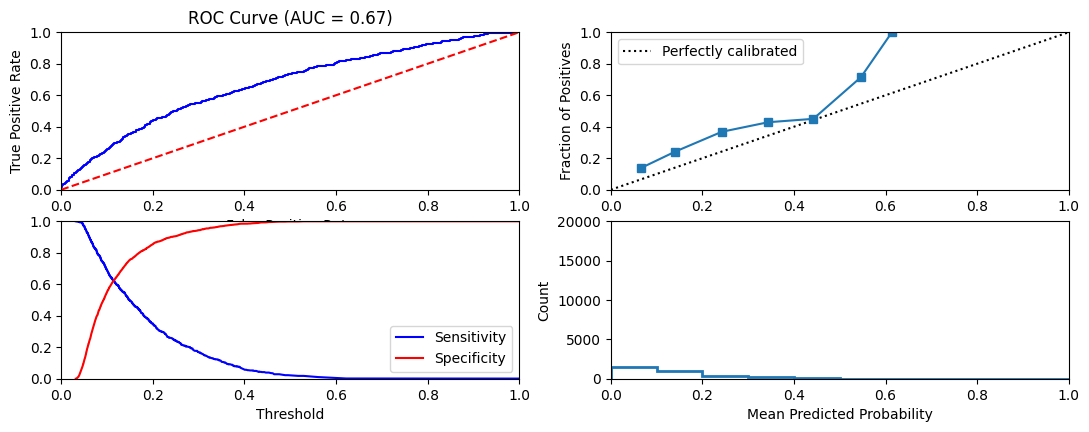


Similarity to LC grade ranking:  0.535830495511584
Brier score: 0.16905365123014668
  Model: MLP_2017
Fit time: 38.5 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.41482800307207346
Accuracy:  0.7736666666666666
              precision    recall  f1-score   support

  No default     0.7745    0.9974    0.8720      2318
     Default     0.6000    0.0132    0.0258       682

    accuracy                         0.7737      3000
   macro avg     0.6873    0.5053    0.4489      3000
weighted avg     0.7349    0.7737    0.6796      3000



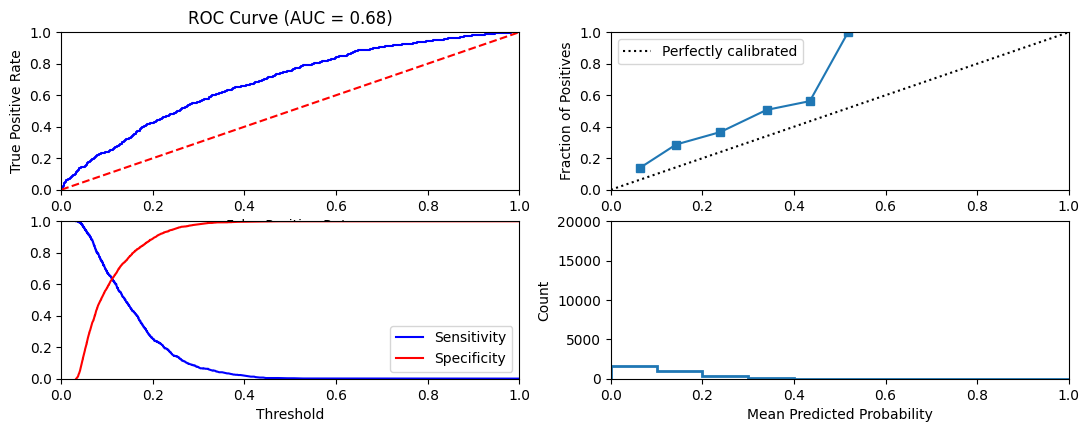


Similarity to LC grade ranking:  0.4819016799202881
Brier score: 0.1759771052289757
F1-score of the model trained on 2010 data: 0.038011695906432746
F1-score of the model trained on 2017 data: 0.02582496413199426


In [ ]:
## Define the time window of your train and test data
from datetime import datetime

start_date_train_2010 = datetime(2010, 1, 1).date()
end_date_train_2010 = datetime(2010, 12, 31).date()

start_date_train_2017 = datetime(2017, 1, 1).date()
end_date_train_2017 = datetime(2017, 12, 31).date()

start_date_test_2018 = datetime(2018, 1, 1).date()
end_date_test_2018 = datetime(2018, 12, 31).date()

data_dict_2010 = prepare_data(date_range_train=(start_date_train_2010, end_date_train_2010),
                              date_range_test=(start_date_test_2018, end_date_test_2018),
                              n_samples_train=5000, n_samples_test=3000, feature_subset=your_features)

data_dict_2017 = prepare_data(date_range_train=(start_date_train_2017, end_date_train_2017),
                              date_range_test=(start_date_test_2018, end_date_test_2018),
                              n_samples_train=5000, n_samples_test=3000, feature_subset=your_features)

# Train and test YourModel (Random Forest) using this data

your_model = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02,
                            activation='tanh', learning_rate_init=1e-04)

trained_model_2010 = fit_classification(your_model, data_dict_2010,
                                        model_name='MLP_2010',
                                        output_to_file=False)

trained_model_2017 = fit_classification(your_model, data_dict_2017,
                                        model_name='MLP_2017',
                                        output_to_file=False)

F1_score_2010 = f1_score(data_dict_2010['y_test'], trained_model_2010['y_pred_labels'])
F1_score_2017 = f1_score(data_dict_2017['y_test'], trained_model_2017['y_pred_labels'])

print(f"F1-score of the model trained on 2010 data: {F1_score_2010}")
print(f"F1-score of the model trained on 2017 data: {F1_score_2017}")

## Train and test YOURMODEL on the original data

In [ ]:
## For Question 6, we need to process our raw data and generate a new data file

# Read the data and features from the pickle file we uploaded
data, discrete_features, continuous_features = pickle.load( open( "/content/gdrive/MyDrive/all_features_clean_data.pickle", "rb" ) )

In [ ]:
# Some discrete features has too many unique variables which will cause us to run out of RAM
# For example, this is where the issue comes from
len(data['emp_title'].unique())

150228

  Model: Multi-layer perceptron_orig_data
Fit time: 51.01 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.41216595329159145
Accuracy:  0.9094
              precision    recall  f1-score   support

  No default     0.9493    0.9288    0.9390      3751
     Default     0.7992    0.8511    0.8244      1249

    accuracy                         0.9094      5000
   macro avg     0.8743    0.8899    0.8817      5000
weighted avg     0.9118    0.9094    0.9103      5000



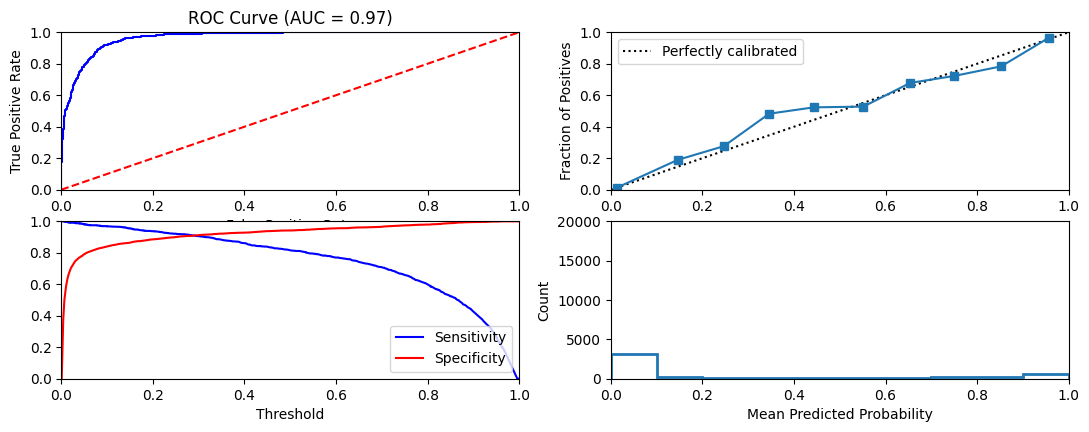


Similarity to LC grade ranking:  0.2679626373976383
Brier score: 0.062352541952816684
Using our own model and applying on all original features, we get accuracy: 0.9094
Also our f1 score: 0.8243505234587049
Index of Less Default Likelihood loan: [3331 3029 4155 2330 4656 4609 2769 2607 2474 4204]


In [ ]:
# We found my code will always ran into bugs if calling the prepare_data()
# So we manually implemented them.

random_state=1
np.random.seed(random_state)
date_range_train = data.issue_d.min(), data.issue_d.max()
date_range_test = data.issue_d.min(), data.issue_d.max()
n_samples_train = 5000
n_samples_test=5000

data["outcome"] = data['loan_status'].apply(lambda info: True if info in ['Charged Off', 'Default'] else False)
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
X_continuous = data[continuous_features].values


## !!!! Issue !!!!: some feature like emp_title, zip_code has too many unique discrete value
# then calling get_dummy() will run out of our RAM
# so we choose to only use the same discrete features as before

discrete_features = ['emp_length',
                    'home_ownership',
                    'term',
                    'grade',
                    'purpose',
                    'verification_status']

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

data_subset = np.array([True]*len(data))
feature_subset = ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
 'addr_state', 'dti', 'total_pymnt', 'delinq_2yrs', 'earliest_cr_line',
 'open_acc', 'pub_rec', 'last_pymnt_d', 'last_pymnt_amnt', 'fico_range_high', 'fico_range_low',
 'last_fico_range_high', 'last_fico_range_low', 'application_type', 'revol_bal', 'revol_util', 'recoveries']

# Filter down the data to the required date range, and downsample
# as required
filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                        (data.issue_d <= date_range_train[1]) & data_subset ).values
filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                        & (data.issue_d <= date_range_test[1]) & data_subset ).values

filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                              - n_samples_train, replace = False ) ] = False
filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                              - n_samples_test, replace = False ) ] = False

# Prepare the training and test set
X_train = X[ filter_train , :]
X_test = X[ filter_test, :]
if feature_subset != None:
    cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                if j.split("::")[0] in feature_subset]
    X_train = X_train[ : , cols ]
    X_test = X_test[ : , cols ]

y_train = y[ filter_train ]
y_test = y[ filter_test ]

# Scale the variables
scaler = preprocessing.MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# return training and testing data
data_dict_full_features = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train,
      'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}


# Define the MLP model
my_MLP = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02,
                            activation='tanh', learning_rate_init=1e-04)
# Replace "random_forest" with the name of your chosen model
my_MLP_out = fit_classification(my_MLP, data_dict_full_features,
                                   model_name ='Multi-layer perceptron_orig_data',
                                   output_to_file=False)

my_MLP_model = my_MLP_out['model']
my_MLP_pred = my_MLP_out['y_pred_labels']

current_acc = accuracy_score(data_dict_full_features['y_test'], my_MLP_pred)

current_f1 = f1_score(data_dict_full_features['y_test'], my_MLP_pred)



print("=============")

print("Using our own model and applying on all original features, we get accuracy: " + str(current_acc))

print("Also our f1 score: " + str(current_f1))

print("Index of Less Default Likelihood loan: " + str((np.argsort(my_MLP_out['y_pred_probs']))[:10]))

## Test regression models

In [ ]:
### Regenerate our default data and it's correlated variables
# otherwise we will mistakenly use a very different data

############################# This is very important!! #############################

data, discrete_features, continuous_features, ret_cols = pickle.load( open( "/content/gdrive/MyDrive/clean_data.pickle", "rb" ) )
data["outcome"] = data['loan_status'].apply(lambda info: True if info in ['Charged Off', 'Default'] else False)
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')
np.random.seed(default_seed)
data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

# We removed 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb' since they are our predicting value
your_features = ['funded_amnt', 'term', 'int_rate', 'grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'dti', 'delinq_2yrs','open_acc', 'pub_rec', 'fico_range_high',
       'fico_range_low', 'revol_bal', 'revol_util','loan_length', 'term_num',
       'cr_hist']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False,
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen

    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''

    np.random.seed(random_state)

    # --------------------------
    #   Step 1 - Load the data
    # --------------------------

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}

    for ret_col in col_list:

        # We changed to "to_numpy" since as_matrix() is no longer supported
        # y_train = data.loc[filter_train, ret_col].as_matrix()
        # y_test = data.loc[filter_test, ret_col].as_matrix()

        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_

            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)

            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2', n_jobs = -1)

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_

            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

## Regresson against all returns

### $l_1$ regularized linear regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters
l1_logistic = Lasso()

cv_parameters = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1]}

reg_lasso = fit_regression(l1_logistic, data_dict, cv_parameters,
                            model_name ='lasso_regularized_linear_regression',
                            output_to_file=False)


  Model: lasso_regularized_linear_regression  Return column: ret_PESS
Fit time: 1.88 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.04565549427818116
  Model: lasso_regularized_linear_regression  Return column: ret_OPT
Fit time: 0.77 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.03133912403524575
  Model: lasso_regularized_linear_regression  Return column: ret_INTa
Fit time: 0.79 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.07533262400612528
  Model: lasso_regularized_linear_regression  Return column: ret_INTb
Fit time: 0.84 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.07298390813920153


### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

l2_logistic = Ridge()

cv_parameters = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1]}

reg_ridge = fit_regression(l2_logistic, data_dict, cv_parameters,
                            model_name ='Ridge_regularized_linear_regression',
                            output_to_file=False)

  Model: Ridge_regularized_linear_regression  Return column: ret_PESS
Fit time: 0.72 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.06262519083285756
  Model: Ridge_regularized_linear_regression  Return column: ret_OPT
Fit time: 0.69 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.04049432900037431
  Model: Ridge_regularized_linear_regression  Return column: ret_INTa
Fit time: 0.74 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.07905770411281332
  Model: Ridge_regularized_linear_regression  Return column: ret_INTb
Fit time: 0.68 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.07362349108918853


### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters
mlp_regressor = MLPRegressor()

cv_parameters = {'hidden_layer_sizes': [tuple([y] * x) for x in [3,5] for y in [18]],
                 'alpha' : [1e-02], 'activation': ['tanh', 'relu'],
                 'learning_rate_init': [1e-04]}

reg_mlp = fit_regression(mlp_regressor, data_dict, cv_parameters,
                            model_name ='MLP regressor',
                            output_to_file=False)

  Model: MLP regressor  Return column: ret_PESS
Fit time: 64.27 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 score: 0.021676188960303655
  Model: MLP regressor  Return column: ret_OPT
Fit time: 65.59 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 score: 0.006815110309727479
  Model: MLP regressor  Return column: ret_INTa
Fit time: 67.58 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 score: 0.0618535516818941
  Model: MLP regressor  Return column: ret_INTb
Fit time: 199.97 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 score: 0.09414747796586653


### Random forest regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
## trying random forest regression with hyper-parameters

random_forest_reg = RandomForestRegressor()

cv_parameters = {"n_estimators":[100, 150],
                 "max_depth" : [2,8,10],
                 "random_state":[default_seed]}

reg_rf = fit_regression(random_forest_reg, data_dict, cv_parameters,
                            model_name ='Random_Forest_Regressor',
                            output_to_file=False)

  Model: Random_Forest_Regressor  Return column: ret_PESS
Fit time: 361.16 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 150, 'random_state': 1}

Testing r2 score: 0.10501959052945409
  Model: Random_Forest_Regressor  Return column: ret_OPT
Fit time: 343.58 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 100, 'random_state': 1}

Testing r2 score: 0.07632061716947391
  Model: Random_Forest_Regressor  Return column: ret_INTa
Fit time: 348.48 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 150, 'random_state': 1}

Testing r2 score: 0.11718678488962331
  Model: Random_Forest_Regressor  Return column: ret_INTb
Fit time: 344.56 seconds
Optimal parameters:
{'max_depth': 8, 'n_estimators': 150, 'random_state': 1}

Testing r2 score: 0.10603247212348799


## Regression against returns for defaulted and nondefaulted loans separately.

model 0 --> nondefaulted data

model 1 --> defaulted data

### l1 regularized linear regression

In [ ]:
l1_logistic = Lasso()

cv_parameters = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1]}

reg_lasso = fit_regression(l1_logistic, data_dict, cv_parameters, separate=True,
                            model_name ='lasso_regularized_linear_regression',
                            output_to_file=False)

  Model: lasso_regularized_linear_regression  Return column: ret_PESS
Fit time: 0.85 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.023059070784334224
model_1: 0.1230294827442544
  Model: lasso_regularized_linear_regression  Return column: ret_OPT
Fit time: 1.3 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.10718124677368857
model_1: 0.11927766901790238
  Model: lasso_regularized_linear_regression  Return column: ret_INTa
Fit time: 1.75 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.024383298278809806
model_1: 0.04061175976458664
  Model: lasso_regularized_linear_regression  Return column: ret_INTb
Fit time: 2.19 seconds
Optimal parameters:
model_0: {'alpha': 0.001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.037445515717065336
model_1: 0.061281444864911605


### l2 regularized linear regression

In [ ]:
## trying l2 regularized linear regression with hyper-parameters

l2_logistic = Ridge()

cv_parameters = {'alpha': [0.001, 0.005, 0.01, 0.05, 0.1]}

reg_ridge = fit_regression(l2_logistic, data_dict, cv_parameters, separate=True,
                            model_name ='Ridge_regularized_linear_regression',
                            output_to_file=False)

  Model: Ridge_regularized_linear_regression  Return column: ret_PESS
Fit time: 0.73 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.06618859045167402
model_1: 0.1411923645183386
  Model: Ridge_regularized_linear_regression  Return column: ret_OPT
Fit time: 0.63 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.12841994712722105
model_1: 0.13619496455872449
  Model: Ridge_regularized_linear_regression  Return column: ret_INTa
Fit time: 0.65 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.04182241610137838
model_1: 0.05585245770276526
  Model: Ridge_regularized_linear_regression  Return column: ret_INTb
Fit time: 0.65 seconds
Optimal parameters:
model_0: {'alpha': 0.1} model_1 {'alpha': 0.1}

Testing r2 scores:
model_0: 0.04384329452422686
model_1: 0.06902650320893067


### Multi-layer perceptron regressor

In [ ]:
mlp_regressor = MLPRegressor()

# Here we only tune the model based on the best hyper-parameter for efficiency
cv_parameters = {'hidden_layer_sizes': [tuple([y] * x) for x in [3,5] for y in [18]],
                 'alpha' : [1e-02], 'activation': ['tanh', 'relu'],
                 'learning_rate_init': [1e-04]}

reg_mlp = fit_regression(mlp_regressor, data_dict, cv_parameters, separate=True,
                            model_name ='MLP regressor',
                            output_to_file=False)

  Model: MLP regressor  Return column: ret_PESS
Fit time: 75.99 seconds
Optimal parameters:
model_0: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001} model_1 {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 scores:
model_0: -0.023998341076846286
model_1: -0.055120717943473396
  Model: MLP regressor  Return column: ret_OPT
Fit time: 66.13 seconds
Optimal parameters:
model_0: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001} model_1 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18, 18), 'learning_rate_init': 0.0001}

Testing r2 scores:
model_0: 0.06292166414618627
model_1: 0.0797949407982248
  Model: MLP regressor  Return column: ret_INTa
Fit time: 78.7 seconds
Optimal parameters:
model_0: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (18, 18, 18, 18,

### Random Forest regressor

In [ ]:
## trying random forest regression with hyper-parameters

random_forest_reg = RandomForestRegressor()

# Here we only tune the model based on the best hyper-parameter for efficiency
cv_parameters = {"n_estimators":[100,150],
                 "max_depth" : [8,10],
                 "random_state":[default_seed]}

reg_rf = fit_regression(random_forest_reg, data_dict, cv_parameters,
                            separate=True,
                            model_name ='Random_Forest_Regressor',
                            output_to_file=False)

  Model: Random_Forest_Regressor  Return column: ret_PESS
Fit time: 390.18 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 150, 'random_state': 1} model_1 {'max_depth': 8, 'n_estimators': 100, 'random_state': 1}

Testing r2 scores:
model_0: 0.14874922376737199
model_1: 0.14965136149500247
  Model: Random_Forest_Regressor  Return column: ret_OPT
Fit time: 387.27 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 150, 'random_state': 1} model_1 {'max_depth': 8, 'n_estimators': 100, 'random_state': 1}

Testing r2 scores:
model_0: 0.19537101305111348
model_1: 0.12004942412989006
  Model: Random_Forest_Regressor  Return column: ret_INTa
Fit time: 384.65 seconds
Optimal parameters:
model_0: {'max_depth': 8, 'n_estimators': 100, 'random_state': 1} model_1 {'max_depth': 10, 'n_estimators': 100, 'random_state': 1}

Testing r2 scores:
model_0: 0.11762683003029584
model_1: 0.06670367918143671
  Model: Random_Forest_Regressor  Return column: ret_INTb
Fit ti

## Test investment strategies
Now we test several investment strategies using the learning models above

In [ ]:
import random
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random',
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns.
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.

    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order

    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file

    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''

    np.random.seed(random_state)

    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']

    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}

    for ret_col in col_list:

        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            idx = random.sample(range(len(data_test)), num_loans)
            pf_test = data_test.loc[idx, :]

            ## Find the average return for these loans
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        elif strategy == 'Return-based':

            colname = 'predicted_return_' + ret_col

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans

            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col

            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return +
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = np.mean(pf_test[ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'

    return out

In [ ]:
## Test investment strategies using the best performing regressor

# col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
# test_strategy = 'Random'

# print('strategy:',test_strategy)
# strat_rand = test_investments(data_dict, strategy=test_strategy)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

M1_list = []
M2_list = []
M3_list = []
M4_list = []
for i in range(100):
  np.random.seed(i)
  data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
  data_dict = prepare_data(feature_subset = your_features, random_state=i)
  # print('strategy:',test_strategy)
  strat_rand = test_investments(data_dict, strategy=test_strategy, random_state=i)

  for ret_col in col_list:
    # print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
    if ret_col == 'ret_PESS':
      M1_list.append(strat_rand[ret_col]['average return'])
    elif ret_col == 'ret_OPT':
      M2_list.append(strat_rand[ret_col]['average return'])
    elif ret_col == 'ret_INTa':
      M3_list.append(strat_rand[ret_col]['average return'])
    else:
      M4_list.append(strat_rand[ret_col]['average return'])
print('strategy:',test_strategy)
print('ret_PESS: ', np.mean(np.array(M1_list)))
print('ret_OPT: ', np.mean(np.array(M2_list)))
print('ret_INTa: ', np.mean(np.array(M3_list)))
print('ret_INTb: ', np.mean(np.array(M4_list)))

In [ ]:
# test_strategy = 'Default-based'

# print('strategy:',test_strategy)
# strat_def = test_investments(...)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

test_strategy = 'Default-based'
M1_list = []
M2_list = []
M3_list = []
M4_list = []

for i in range(100):
  np.random.seed(i)
  data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
  data_dict = prepare_data(feature_subset = your_features, random_state=i)

  mlp = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02, activation='tanh', learning_rate_init=1e-04)
  clf = fit_classification(mlp, data_dict, output_to_file=False, print_to_screen = False)
  # print('strategy:',test_strategy)
  strat_def = test_investments(data_dict, classifier=clf, strategy=test_strategy)

  for ret_col in col_list:
    # print(ret_col + ': ' + str(strat_def[ret_col]['average return']))
    if ret_col == 'ret_PESS':
      M1_list.append(strat_def[ret_col]['average return'])
    elif ret_col == 'ret_OPT':
      M2_list.append(strat_def[ret_col]['average return'])
    elif ret_col == 'ret_INTa':
      M3_list.append(strat_def[ret_col]['average return'])
    else:
      M4_list.append(strat_def[ret_col]['average return'])
print('strategy:',test_strategy)
print('ret_PESS: ', np.mean(np.array(M1_list)))
print('ret_OPT: ', np.mean(np.array(M2_list)))
print('ret_INTa: ', np.mean(np.array(M3_list)))
print('ret_INTb: ', np.mean(np.array(M4_list)))

strategy: Default-based
ret_PESS:  0.012160873983247653
ret_OPT:  0.03280693905238079
ret_INTa:  0.4117633550511419
ret_INTb:  1.232297350103522


In [ ]:
# test_strategy = 'Return-based'

# print('strategy:',test_strategy)
# strat_ret = test_investments(...)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))


test_strategy = 'Return-based'
M1_list = []
M2_list = []
M3_list = []
M4_list = []

for i in range(100):
  np.random.seed(i)
  data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
  data_dict = prepare_data(feature_subset = your_features, random_state=i)

  rf = RandomForestRegressor(max_depth=8, n_estimators=150, random_state=1)
  reg = fit_regression(rf, data_dict, output_to_file=False, print_to_screen=False)
  # print('strategy:',test_strategy)
  strat_ret = test_investments(data_dict, regressor=reg, strategy=test_strategy, random_state=i)

  for ret_col in col_list:
    # print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))
    if ret_col == 'ret_PESS':
      M1_list.append(strat_ret[ret_col]['average return'])
    elif ret_col == 'ret_OPT':
      M2_list.append(strat_ret[ret_col]['average return'])
    elif ret_col == 'ret_INTa':
      M3_list.append(strat_ret[ret_col]['average return'])
    else:
      M4_list.append(strat_ret[ret_col]['average return'])
print('strategy:',test_strategy)
print('ret_PESS: ', np.mean(np.array(M1_list)))
print('ret_OPT: ', np.mean(np.array(M2_list)))
print('ret_INTa: ', np.mean(np.array(M3_list)))
print('ret_INTb: ', np.mean(np.array(M4_list)))

strategy: Return-based
ret_PESS:  0.0289280748928591
ret_OPT:  0.03550491437143133
ret_INTa:  0.41204747083463344
ret_INTb:  1.2290289232826006


In [ ]:
# test_strategy = 'Default-return-based'

# ## For the Default-return-based strategy we need to fit a new regressor with separate = True
# cv_parameters = ...

# reg_separate = fit_regression(...)

# print('strategy:',test_strategy)
# strat_defret = test_investments(...)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))


test_strategy = 'Default-return-based'

M1_list = []
M2_list = []
M3_list = []
M4_list = []

for i in range(100):
  np.random.seed(i)
  data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
  data_dict = prepare_data(feature_subset = your_features, random_state=i)

  ## For the Default-return-based strategy we need to fit a new regressor with separate = True
  # cv_parameters = ...
  # new regressors already fitted in sections above
  rf = RandomForestRegressor(max_depth=8, n_estimators=150, random_state=1)
  reg_separate = fit_regression(rf, data_dict, separate=True, output_to_file=False, print_to_screen=False)
  mlp = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02, activation='tanh', learning_rate_init=1e-04)
  clf = fit_classification(mlp, data_dict, output_to_file=False, print_to_screen = False)
  # print('strategy:',test_strategy)
  strat_defret = test_investments(data_dict, classifier=clf, regressor=reg_separate, strategy=test_strategy, random_state=i)

  for ret_col in col_list:
    # print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))
    if ret_col == 'ret_PESS':
      M1_list.append(strat_defret[ret_col]['average return'])
    elif ret_col == 'ret_OPT':
      M2_list.append(strat_defret[ret_col]['average return'])
    elif ret_col == 'ret_INTa':
      M3_list.append(strat_defret[ret_col]['average return'])
    else:
      M4_list.append(strat_defret[ret_col]['average return'])
print('strategy:',test_strategy)
print('ret_PESS: ', np.mean(np.array(M1_list)))
print('ret_OPT: ', np.mean(np.array(M2_list)))
print('ret_INTa: ', np.mean(np.array(M3_list)))
print('ret_INTb: ', np.mean(np.array(M4_list)))

strategy: Default-return-based
ret_PESS:  0.02720052868241249
ret_OPT:  0.034805771554564394
ret_INTa:  0.4097883605035645
ret_INTb:  1.2392786747951126


## Sensitivity test of portfolio size

In [ ]:
# Optimal model from Q7
rf = RandomForestRegressor(max_depth=8, n_estimators=150, random_state=1)
reg_separate = fit_regression(rf, data_dict, separate=True, output_to_file=False, print_to_screen=False)
mlp = MLPClassifier(hidden_layer_sizes=(18, 18, 18, 18, 18), alpha=1e-02, activation='tanh', learning_rate_init=1e-04)
clf = fit_classification(mlp, data_dict, output_to_file=False, print_to_screen = False)

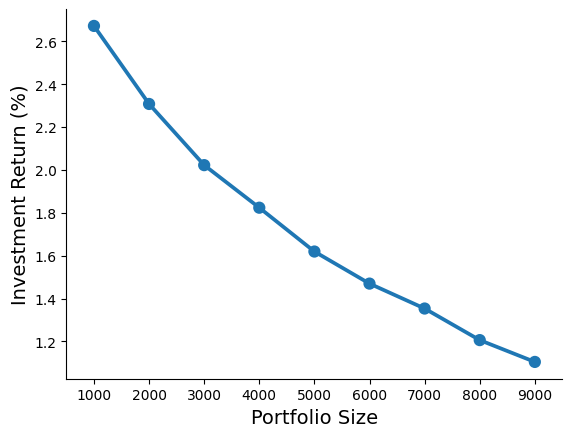

In [ ]:
## Test the best-performing data-driven strategy on different portfolio sizes
result_sensitivity = []

test_strategy = 'Default-return-based'

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
  temp_results = []
  # we random split 100 times here because for the 1,000 loans, we also random split 100 times as well
  # to make it fair for any loan num, we also conduct the random split 100 times and then take the avg
  for random_seed in range(1, 101):
    # the best strategy from the question 7
    reg_0 = test_investments(data_dict, classifier=clf, regressor=reg_separate, strategy=test_strategy,
                             random_state= random_seed, num_loans = num_loans)
    temp_results.append(reg_0['ret_PESS']['average return'])

  avg_result = np.mean(temp_results)
  result_sensitivity.append(avg_result)

result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(x = np.array(list(range(1000,10000,1000))),y = result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()